In [3]:
import pandas as pd
from sklearn.utils import resample
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
# Load the dataset
dataset = pd.read_csv('/content/final_dataset.csv')

In [29]:
dataset.head()

,text,label
0,Rajdeep refused to acknowledge Kolkata rape-mu...,FAKE
1,‘Ram tapakna’: Kumari Selja’s remarks taken ou...,FAKE
2,"‘Bhola’, ‘Shankar’ were aliases used by IC 814...",FAKE
3,Kejriwal called Uddhav Thackeray Balasaheb’s ‘...,FAKE
4,Karachi video from 2023 viral as Muslim kids s...,FAKE


In [5]:
# Step 1: Remove rows with missing 'text' values
dataset_cleaned = dataset.dropna(subset=['text'])



In [6]:
# Step 2: Separate the majority and minority classes
real = dataset_cleaned[dataset_cleaned['label'] == 'REAL']
fake = dataset_cleaned[dataset_cleaned['label'] == 'FAKE']

In [7]:
# Step 3: Oversample the minority class (FAKE)
fake_oversampled = resample(fake,
                            replace=True,      # Sample with replacement
                            n_samples=len(real), # Match number of majority class
                            random_state=42)   # For reproducibility

In [8]:
# Step 4: Combine oversampled minority class with majority class
balanced_dataset = pd.concat([real, fake_oversampled])

In [9]:
# Step 5: Shuffle the dataset to mix the samples
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)


#Text Preprocessing

In [10]:
# Text Preprocessing Function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text


In [11]:
# Apply text preprocessing
balanced_dataset['text'] = balanced_dataset['text'].apply(preprocess_text)

In [12]:
# Verify the preprocessing by checking the first few rows
print("Sample of preprocessed text:")
print(balanced_dataset[['text', 'label']].head())

Sample of preprocessed text:
                                                text label
0      lanes delhis narela sealed covid cases emerge  REAL
1  fact check did putins daughter die receiving c...  FAKE
2  cg peg assistant programmer admit cards releas...  REAL
3  clipped video ravish kumars program circulated...  FAKE
4  pdp expels rajya sabha mp antiparty activities...  REAL


In [13]:
# Verify the new class distribution
print("Class distribution after balancing:")
print(balanced_dataset['label'].value_counts())

Class distribution after balancing:
label
REAL    39792
FAKE    39792
Name: count, dtype: int64


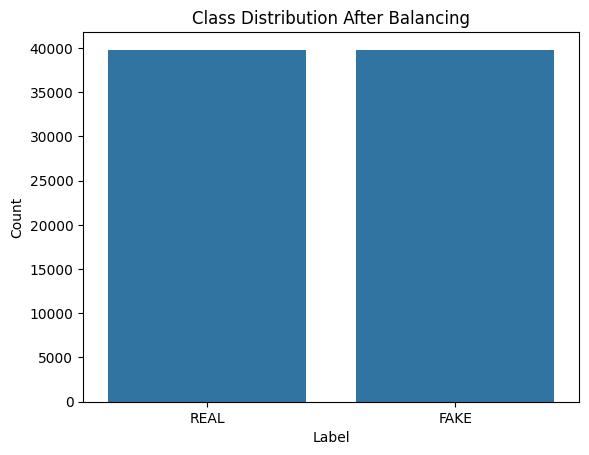

In [14]:
# Visualize class distribution
sns.countplot(data=balanced_dataset, x='label')
plt.title("Class Distribution After Balancing")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [15]:
# Step 6: Prepare the dataset for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(texts, labels, max_len=128):
    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )
    input_ids = torch.tensor(encoded['input_ids'])
    attention_masks = torch.tensor(encoded['attention_mask'])
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
# Map labels to integers
label_map = {'REAL': 0, 'FAKE': 1}
balanced_dataset['label'] = balanced_dataset['label'].map(label_map)

In [17]:
# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_dataset['text'], balanced_dataset['label'], test_size=0.2, random_state=42)


In [18]:
# Encode the data for BERT
train_inputs, train_masks, train_labels = encode_data(train_texts.tolist(), train_labels.tolist())
test_inputs, test_masks, test_labels = encode_data(test_texts.tolist(), test_labels.tolist())

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
# Step 7: Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Step 8: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Step 9: Create DataLoader and Trainer
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

# Define a custom data collator function
def custom_data_collator(features):
    """
    Custom data collator to handle TensorDataset.
    """
    # Convert the list of tuples to a dictionary
    return {
        'input_ids': torch.stack([f[0] for f in features]),
        'attention_mask': torch.stack([f[1] for f in features]),
        'labels': torch.stack([f[2] for f in features])
    }

trainer = Trainer(
    model=model,                         # the pre-trained BERT model
    args=training_args,                  # training arguments
    train_dataset=train_data,            # training dataset
    eval_dataset=test_data,              # evaluation dataset
    data_collator=custom_data_collator   # use the custom data collator
)


In [23]:
# Step 10: Train the model
trainer.train()

# Save the trained model
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.127700,0.169915
2,0.067800,0.141720
3,0.013700,0.143816


('./bert_model/tokenizer_config.json',
 './bert_model/special_tokens_map.json',
 './bert_model/vocab.txt',
 './bert_model/added_tokens.json')

Evaluation Report:
              precision    recall  f1-score   support

        REAL       0.97      0.97      0.97      7997
        FAKE       0.97      0.97      0.97      7920

    accuracy                           0.97     15917
   macro avg       0.97      0.97      0.97     15917
weighted avg       0.97      0.97      0.97     15917



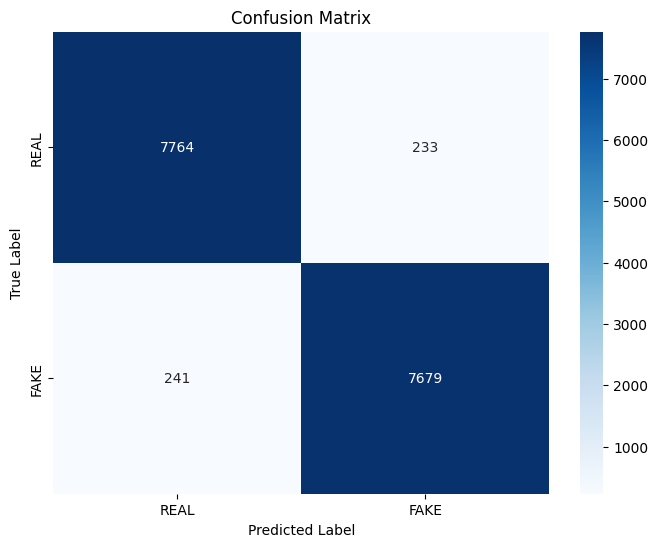

In [24]:
# Step 11: Evaluate the model
predictions = trainer.predict(test_data)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

eval_report = classification_report(test_labels, preds, target_names=['REAL', 'FAKE'])
print("Evaluation Report:")
print(eval_report)

# Visualize the confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
def predict_fake_news(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits).item()
    return "FAKE" if predicted_class == 1 else "REAL"

example_text_real = "Rajdeep refused to acknowledge Kolkata rape-muder."
example_text_fake = "Aliens have landed and are taking over the world!"


prediction_real = predict_fake_news(example_text_real)
prediction_fake = predict_fake_news(example_text_fake)

print(f"'{example_text_real}' classified as: {prediction_real}")
print(f"'{example_text_fake}' classified as: {prediction_fake}")

'Rajdeep refused to acknowledge Kolkata rape-muder.' classified as: FAKE
'Aliens have landed and are taking over the world!' classified as: FAKE
